# Metodologia para simulação númerica

Dada a função de benchmark com duas variavéis c $x_1$ e $x_2$ como entradas

$$
    f(x_1, x_2) = 1.3356(1.5(1-x_1))
                + e^{2x_1 - 1}sen(3\pi(x_1 - 0.6)^2)
                + e^{3(x_2 - 0.5)}sen(4\pi(x_2 - 0.9)^2)
$$

Aonde $x_1$ e $x_2$ são mutualmente independentes; $\hat{x} = [x1, x2]^T$ diz respeito a distribuição padrão e uniforme com $\hat{x} \sim U(0, 1)$

1. Selecionar conjunto de dados original com 30 pontos e computar a projeção $s$ de cada amostra ao longo de cada dimensão
2. Calcular a distância média para todos os pontos ordenados e projetados na dimensão de $x_1$ segundo a equação
$$ avgDist = \frac{1}{n-1}\sum_{i=1}^{n-1} dist(s_i^m, s_{i+1}^m) $$ 
$$ dist(s_i^m, s_{i+1}^m) = \left \| s_i^m s_{i+1}^m   \right \|^2 ; i = 1, 2, ..., n-1; m = 1, 2, ..., d $$
3. Encontrar regiões esparsas definidas por 
 $$ avgDist \leq dist_i$$
4. Gerar um novo ponto $x_i^{\sim m}$ no centro do intervalo esparso
$$x_i^{\sim m} = \frac{1}{2}(s_i^m, s_{i+1}^m)$$
5. Calcular quantis para $x_2$
6. Para cada novo ponto na dimensão $x_1$, combinar com os quantis de $x_2$ para gerar amostras virtuais multidimensionais. 


>fisherman first fixes the other directions of the fishing nets with some predetermined fibers, and then draws the fibers from the remaining single direction, thereby interweaving the fibers in different directions into mesh structures

Quantis são pontos estabelecidos em intervalos regulares a partir de uma função de distribuição acumulada de uma variável aleatória. Os quantis dividem os dados ordenados em q subconjuntos de dados de dimensão essencialmente igual.

- Primeiro quartil (Q1): 0.25 
- Segundo quartil (Q2): 0.5 é a mediana, 50% dos valores estão acima e 50% abaixo
- Terceiro quartil (Q3): 0.75
- Percentil: Dividem os dados em 100 parte iguais

São úteis para entender a distribuição dos dados e identificar *valores representativos* dentro do conjunto de dados.

Em vez de apenas adicionar novos pontos na mesma dimensão onde o intervalo esparso foi identificado, combinamos esses novos pontos com valores representativos (quantis) das outras dimensões.

Por exemplo, se identificamos um intervalo esparso na dimensão de $x_1$, geramos novos pontos no meio deste intervalo e combinamos esses pontos com quantis de $x_2$ para gerar amostras multidimensionais.

Combinando novos pontos gerados em regiões esparsas com quantis de outras dimensões, garantimos que os novos pontos adicionados são representativos e mantêm a variabilidade das amostras originais, cobrindo regiões do espaço de entrada que poderiam estar subamostradas.

Tomando $Q^m_{\alpha}$ = $\alpha$ quantil dos pontos de projeção que satisfaz $P(s^m \leq Q^m_{\alpha}) = \alpha$ têm se 
$$ x_i^{\sim q} = Q^m_{\alpha}$$ 
Para todas as dimensões exceto a m-ésima 

Combinando os novos pontos atraves de todas as dimensões, as amostras virtuais podem ser geradas no espaço da entrada como

$$ x_i^{\sim k} =\left\{\begin{matrix}
 \frac{1}{2}(s_i^m, s_{i+1}^m) ; k = m; avgDist \leq dist_i \\
 Q^m_{\alpha} ; k = q; q = \{ 1, 2, ..., d\}; q \neq m
\end{matrix}\right.
 $$

- O metódo proposto pode gerar não mais que $(n - 1)d|Q_{\alpha}|{d-1}$ amostras
- Para que as amostra virtuais cubram todo o espaço de entrada, convém escolher $\alpha$ de $[0.025, 0.25, 0.5, 0.75, 0.975]$ para que $Q_{\alpha}$ represente a distribuição subjacente dos pontos originais

> A saida das amostras virtuais $\tilde{x_i}$ geradas no espaço de entrada podem ser determinadas no espaço de saida usando o metodo Kriging pré estabilizado de aproximação de modelo baseado no conjunto de dados originais

$$ Z^{*}(\bar{x_0}) = \mu(\bar{x}) + \sum _{i=1}^{n} \lambda_i (Z(\bar{x_i} - \mu(\bar{x}))) $$

$$ A\lambda = b$$


## 1. Importando dados


In [1]:
import numpy as np
import pandas as pd
import numpy as np
from pylab import *

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def create_dataframe(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(4)
df_training = create_dataframe(5)

/tmp/ipykernel_2418/387747909.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt

class KrigingVSG:
    def __init__(self, original_samples_x, original_samples_y):
        self.original_samples_x = np.array(original_samples_x)
        self.original_samples_y = np.array(original_samples_y)
        self.d = self.original_samples_x.shape[1]
        self.kriging_model = None
        self.virtual_samples_x = []
        self.virtual_samples_y = []

    def ComputeProjection(self):
        projections = []

        for m in range(self.d):
            x = self.original_samples_x[:, m]
            v = self.original_samples_x[:, m]
            xm_proj = (np.dot(x, v) / np.linalg.norm(v) ** 2) * v
            projections.append(np.array(np.sort(xm_proj)))
        
        return projections

    def BuildModel(self, VariogramType):
        self.kriging_model = OrdinaryKriging(
            self.original_samples_x[:, 0], 
            self.original_samples_x[:, 1], 
            self.original_samples_y, 
            variogram_model=VariogramType
        )
    

    def SetInputSpace(self):
        projections = self.ComputeProjection()
        avg_dists = [np.mean(np.diff(proj)) for proj in projections]

        Q_alpha = (np.quantile(projections, [0.025, 0.25, 0.5, 0.75, 0.9750], axis=1, method="hazen")).T
        for m in range(self.d):
            for i in range(len(projections[m]) - 1):
                dist = projections[m][i + 1] - projections[m][i]
                if dist > avg_dists[m]:
                    G = (projections[m][i] + projections[m][i + 1]) / 2

                    for q in range(self.d): # expande amostra gerada para a dimensão dos quantis (G, Q_0.025)...
                        if q != m:
                            tilde_q = np.zeros(self.d)
                            for quantile in Q_alpha[q]:
                                tilde_q[m] =  G
                                tilde_q[q] = quantile
                                self.virtual_samples_x.append(np.array(tilde_q)) 
        self.virtual_samples_x = np.array(self.virtual_samples_x)

    def getX(self):
        df = pd.DataFrame({"x1": self.virtual_samples_x[:, 0],
                           "x2": self.virtual_samples_x[:, 1]})
        return(df["x1"], df["x2"])

    
    def ComputeY(self, VariogramType):
        self.BuildModel(VariogramType)
        self.SetInputSpace()
        x1, x2 = self.getX()
        self.virtual_samples_y = self.kriging_model.execute('points', x1, x2)[0]

        self.virtual_samples_df = pd.DataFrame({"x1": x1,
                            "x2": x2,
                           "f(x1,x2)": self.virtual_samples_y})
        return(self.virtual_samples_df)

    def PrintInputSpace(self):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.original_samples_x[:, 0], self.original_samples_x[:, 1], c='blue', label='Amostras Originais', alpha=0.6)
        # plt.scatter(self.virtual_samples_x[:, 0], self.virtual_samples_x[:, 1], c='red', label='Amostras Virtuais', alpha=0.6)
        # plt.scatter(df_test['x1'].values, df_test['x2'].values, c='yellow', label='Amostras de Teste', alpha=0.6)

        plt.xticks(np.arange(0, 1.1, 0.1))  
        plt.yticks(np.arange(0, 1.1, 0.1))  
        plt.grid(which='both', linestyle='--', linewidth=0.5)

        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title(f'Projeção bidimensional das amostras originais e virtuais')
        plt.legend(loc='center', bbox_to_anchor=(0.5, -0.15), frameon=False)
        plt.grid(True)
        return(plt)

In [3]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from scipy.spatial import Delaunay
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

# Função para prever pontos não amostrados
def predictUnsampled(model, mesh_x=80, mesh_y=100):
    Z = np.zeros((mesh_x, mesh_y))
    dx, dy = 1 / mesh_y, 1 / mesh_x

    X, Y = [], []
    for i in range(mesh_x):
        print(i, end=' ')
        for j in range(mesh_y):
            Z[i, j] = model.execute('points', dx * j, dy * i)[0]
            X.append(dx * j)
            Y.append(dy * i)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y, Z


def ComputeMetrics(model, df):
    train_pred = model.execute('points', df_training['x1'], df_training['x2'])[0]
    test_pred  = model.execute('points', df_test['x1'], df_test['x2'])[0]
    sup_pred  = model.execute('points', df_1000['x1'], df_1000['x2'])[0]
    orig_vs = benchmark(df["x1"], df["x2"])
    return ({
                    'r2_sup': r2_score(df_1000["f(x1,x2)"], sup_pred),
                    'mse_sup': mean_squared_error(df_1000["f(x1,x2)"], sup_pred),
                    'mape_sup': mean_absolute_percentage_error(df_1000["f(x1,x2)"], sup_pred),
                    'rmse_sup': root_mean_squared_error(df_1000["f(x1,x2)"], sup_pred),

                    'r2_training': r2_score(df_training['f(x1,x2)'], train_pred),
                    'mse_training': mean_squared_error(df_training['f(x1,x2)'], train_pred),
                    'mape_training': mean_absolute_percentage_error(df_training['f(x1,x2)'], train_pred),
                    'rmse_training': root_mean_squared_error(df_training['f(x1,x2)'], train_pred),

                    'r2_test': r2_score(df_test['f(x1,x2)'], test_pred),
                    'mse_test': mean_squared_error(df_test['f(x1,x2)'], test_pred),
                    'mape_test': mean_absolute_percentage_error(df_test['f(x1,x2)'], test_pred),
                    'rmse_test': root_mean_squared_error(df_test['f(x1,x2)'], test_pred),

                    'r2_vs': r2_score(orig_vs, df['f(x1,x2)']),
                    'mse_vs': mean_squared_error(orig_vs, df['f(x1,x2)']),
                    'mape_vs': mean_absolute_percentage_error(orig_vs, df['f(x1,x2)']),
                    'rmse_vs': root_mean_squared_error(orig_vs, df['f(x1,x2)']),
                },
                sup_pred)


# Função para plotar a superfície
def PlotSurface(X, Y, Z, virtual_samples,  model_name, mesh_x=80, mesh_y=100):
    x_sup, y_sup, z_sup = df_1000['x1'], df_1000['x2'], df_1000['f(x1,x2)']
    x_orig, y_orig, z_orig = df_training['x1'], df_training['x2'], df_training['f(x1,x2)']

    points = np.column_stack((x_sup, y_sup))
    tri = Delaunay(points)

    # Criar a superfície original
    fig_surface = ff.create_trisurf(x=x_sup, y=y_sup, z=z_sup, simplices=tri.simplices, colormap='Greys')

    # Criar a superfície virtual
    virtual_surface = go.Surface(
        x=X.reshape(mesh_x, mesh_y),
        y=Y.reshape(mesh_x, mesh_y),
        z=Z,
        colorscale="ice",
        showscale=False,
        contours=dict(
            z=dict(
                show=True,
                start=np.min(Z),
                end=np.max(Z),
                size=0.05,
                usecolormap=True,
                project_z=True
            )
        )
    )

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(x=x_orig, y=y_orig, z=z_orig, mode='markers',
                               marker=dict(size=5, color='blue', opacity=0.8),
                               name='Original Samples', showlegend = True))
    
    # fig.add_trace(go.Scatter3d(x=virtual_samples['x1'], y=virtual_samples['x2'], z=virtual_samples['f(x1,x2)'],
    #                            mode='markers',
    #                            marker=dict(size=5, color='blue', opacity=0.8),
    #                            name='Virtual Samples', showlegend = True))

    fig.add_trace(fig_surface.data[0])

    fig.add_trace(virtual_surface)

    fig.update_layout(
        title=f'Surface fit for {model_name} variogram',
        scene=dict(
            xaxis_title='x1',
            yaxis_title='x2',
            zaxis_title='f(x1, x2)',
            aspectmode='cube',
            xaxis = dict(backgroundcolor = "white"),
            yaxis = dict(backgroundcolor = "white"),
            zaxis = dict(backgroundcolor = "white"),

        )
    )
    return(fig)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

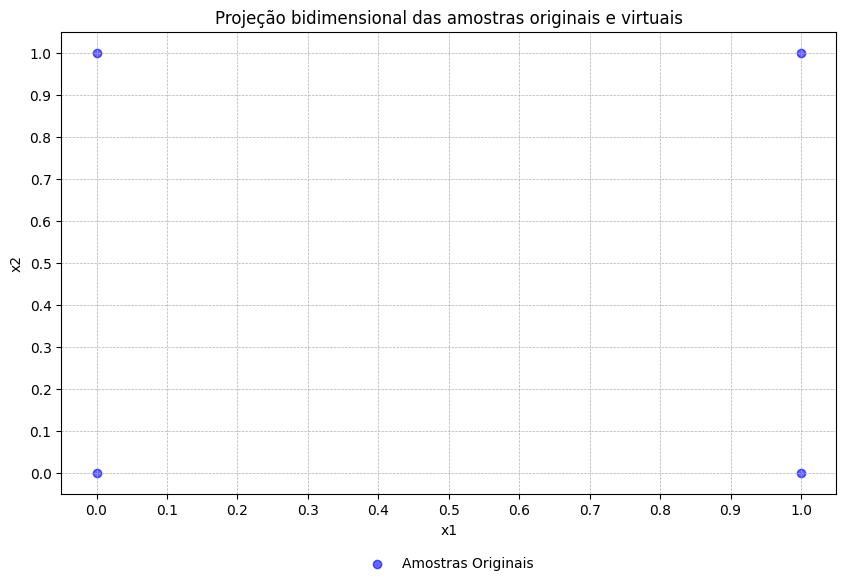

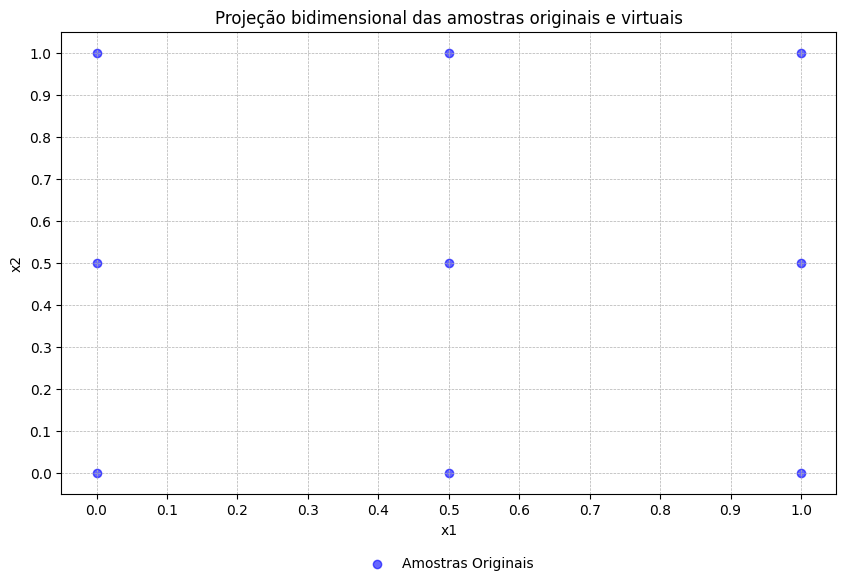

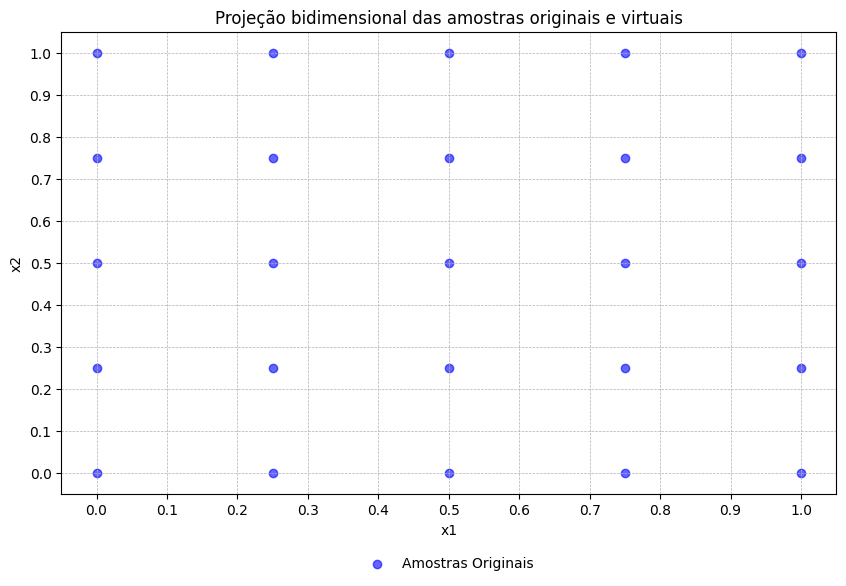

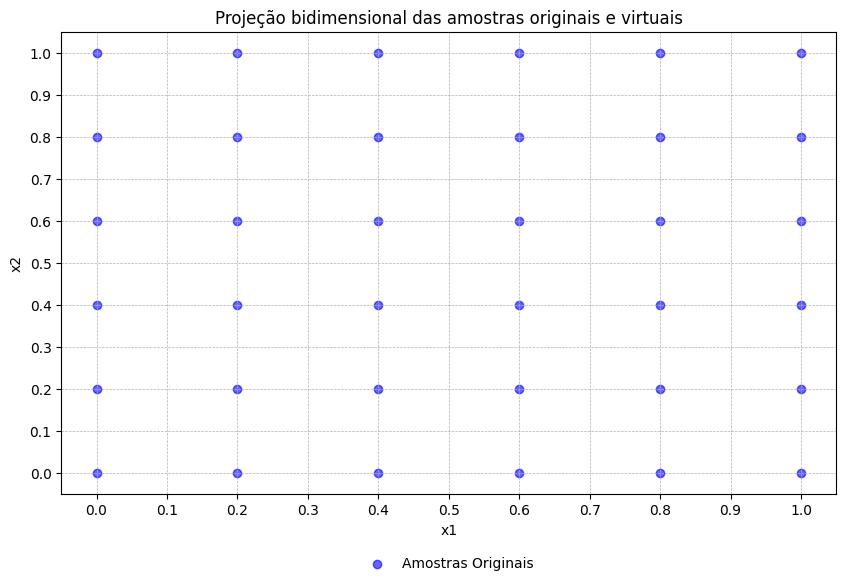

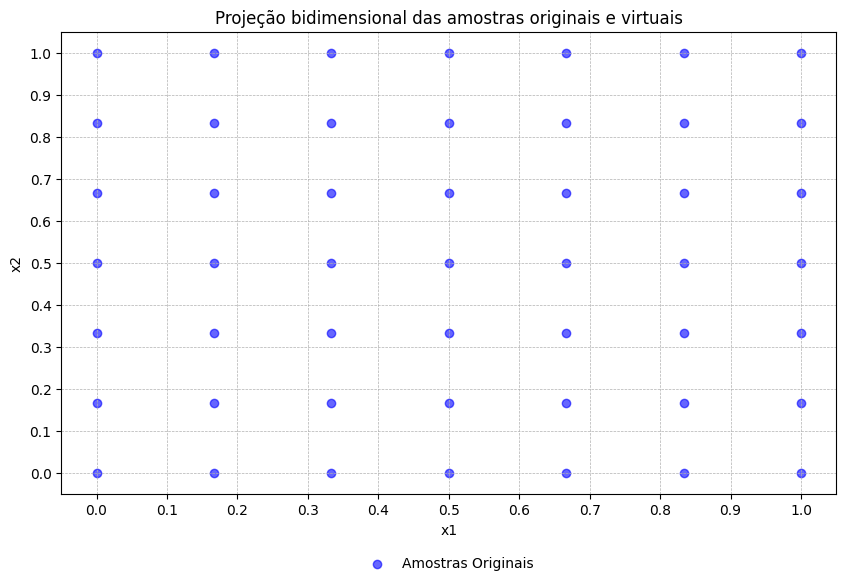

In [4]:
import os

df = df_1000

def createFile(df, file_name, label):
    if not os.path.isfile(file_name):
    # Cria o arquivo Saidas.xlsx se ele não existir
        with pd.ExcelWriter(file_name, mode='w', engine='openpyxl') as writer_vs:
            df.to_excel(writer_vs, sheet_name=label, index=False)
    else:
    # Caso o arquivo já exista, abre no modo de apêndice e salva
        with pd.ExcelWriter(file_name, mode='a', engine='openpyxl') as writer_vs:
            df.to_excel(writer_vs, sheet_name=label, index=False)

for training in [2, 3, 5, 6, 7]:
    label = f'{training}'
    df_training = create_dataframe(grid=training)

    Generator = KrigingVSG(df_training[['x1', 'x2']].values, df_training['f(x1,x2)'].values)
    space = Generator.PrintInputSpace()
    space.savefig(f"InputSpace-{label}.png", format='png')

    gaussian_df = Generator.ComputeY('gaussian')
    X, Y, Z = predictUnsampled(Generator.kriging_model)
    surf = PlotSurface(X, Y, Z, gaussian_df, label)
    surf.write_image(f"Surface-{label}.png")

    metrics_gss, sup_pred = ComputeMetrics(Generator.kriging_model, gaussian_df)
    df[label] = sup_pred
    gss_metrics_df = pd.DataFrame(metrics_gss, index=[0])
    
    createFile(gss_metrics_df, "gssMetrics.xlsx", label)

createFile(df, "Saidas.xlsx", label)


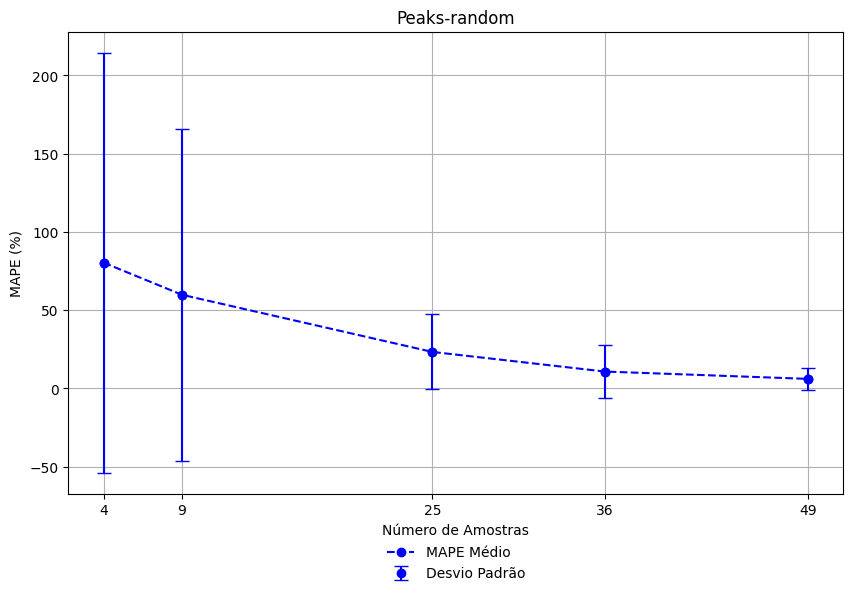

In [5]:
true_values = df['f(x1,x2)']
num_samples = []
mape_means = []
mape_stds = []

for col in df.columns[3:]:  # Pula as colunas x1, x2 e f(x1,x2)
    num_samples.append(int(col.split('_')[0])  ** 2)  # Extrai o número de amostras do nome da coluna
    pred_values = df[col]
    mape = np.abs((true_values - pred_values) / true_values) * 100
    mape_means.append(mape.mean())  # MAPE médio para a coluna atual
    mape_stds.append(mape.std())    # Desvio padrão do MAPE

# Criação do gráfico de linha com barras de erro
plt.figure(figsize=(10, 6))
plt.plot(num_samples, mape_means, marker='o', linestyle='--', color='blue', label='MAPE Médio')
plt.errorbar(num_samples, mape_means, yerr=mape_stds, fmt='o', capsize=5, color='blue', label='Desvio Padrão')

plt.xlabel('Número de Amostras')
plt.ylabel('MAPE (%)')
plt.title('Peaks-random')
plt.xticks(num_samples)  # Define os rótulos do eixo x
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.15), frameon=False)

# Exibe o gráfico
plt.grid()
plt.show()

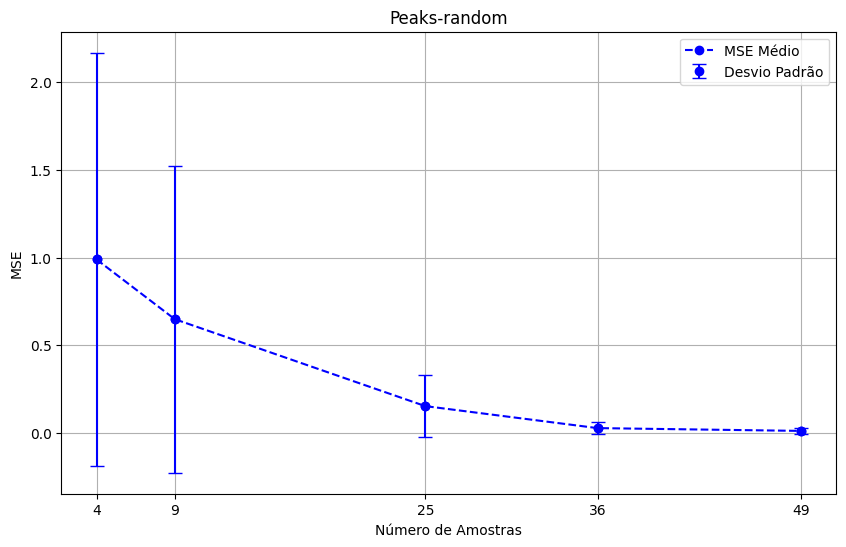

In [7]:
true_values = df['f(x1,x2)']
num_samples = []
mse_means = []
mse_stds = []

for col in df.columns[3:]:  # Pula as colunas x1, x2 e f(x1,x2)
    num_samples.append(int(col.split('_')[0]) ** 2)  # Extrai o número de amostras do nome da coluna
    pred_values = df[col]
    mse = (true_values - pred_values) ** 2  # Erro quadrático
    mse_means.append(mse.mean())  # MSE médio para a coluna atual
    mse_stds.append(mse.std())    # Desvio padrão do MSE

# Criação do gráfico de linha com barras de erro
plt.figure(figsize=(10, 6))
plt.plot(num_samples, mse_means, marker='o', linestyle='--', color='blue', label='MSE Médio')
plt.errorbar(num_samples, mse_means, yerr=mse_stds, fmt='o', capsize=5, color='blue', label='Desvio Padrão')

plt.xlabel('Número de Amostras')
plt.ylabel('MSE')
plt.title('Peaks-random')
plt.xticks(num_samples)  # Define os rótulos do eixo x
plt.legend()

# Exibe o gráfico
plt.grid()
plt.show()